# Importing Libraries

In [1]:
import os
import csv
from collections import Counter
import spacy
import re
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Creating Spacy Model for Tokenization

In [2]:
nlp = spacy.blank('ur')

## Importing Stop Words Text file

In [3]:
with open("data/stopwords-ur.txt",encoding="utf-8") as f:
    reader = csv.reader(f)
    stop_words_data = list(reader)
stop_words_data = [x for y in stop_words_data for x in y]

# Pre-processing and fetching data

Includes:
* Creating list of characters that need to be ignored 
* Importing data directly from different files
* Tokenizing each file and based on the selection of Boolean/Multinomial, append approproately to the main document
* Returning the document along with words count

In [4]:
ignore_characters_list = ['۔','-','۔','،','‘','’','؟',"''",":",'"','”','“',"'","!","(",")","۔","۔"]

In [5]:
def get_data(includeStopWords=1,isBoolean=0,data_type="Real"):
    all_files = os.listdir("data/Train/"+data_type+"/") #Getting all files from the ./data/Train/Real folder
    comb_data = []
    for i in all_files:
        with open("data/Train/"+data_type+"/"+i,encoding="utf-8") as f:
            reader = csv.reader(f)
            data = list(reader)
            data = [x for y in data for x in y]
            for k in ignore_characters_list:
                for i,j in enumerate(data):
                    if(k in j):
                        data[i] = data[i].replace(k," ")
            data = [nlp(x) for x in data]
            data2 = [str(x).strip() for y in data for x in y]
            if(includeStopWords==0):
                data2 = [x for x in data2 if x not in stop_words_data]
            if(isBoolean):
                comb_data.append(list(set(data2)))
            else:
                comb_data.append(data2)

    Document = [x for y in comb_data for x in y]
    Document = [x for x in Document if x not in ignore_characters_list]
    all_words = [x for x in Document if x != ""]
    all_words = [x for x in all_words if x != " "]
    words_count = Counter(all_words)
    return all_words, words_count

# Get Vocabulary : 
* Gets all words from real and fake words, appends them and removes duplicates

In [6]:
def get_vocabulary(real_words,fake_words):
    all_vocab = [fake_words,real_words]
    all_vocab = [x.strip() for y in all_vocab for x in y]
    return list(set(all_vocab))

# Calculating Priors: \$ P(c=real)  and P(c=fake) $

In [7]:
def get_probabilities_class():
    real_files = os.listdir("data/Train/Real") #Getting all files from the ./data/Train/Real folder
    fake_files = os.listdir("data/Train/Fake") #Getting all files from the ./data/Train/Fake folder
    
    P_r = len(real_files)/(len(real_files)+len(fake_files))
    P_f = len(real_files)/(len(real_files)+len(fake_files))
    return P_r,P_f

# Calculating Likelihood   $P(t|c)$

In [8]:
def cond_probab(words,words_freq,all_vocab):
    probab = {}
    n = len(words)
    v = len(all_vocab)    

    for i in all_vocab:
        try:
            nk= words_freq[i]
        except:
            nk = 0
            print("else_triggered")
        probab[i] = (nk+1)/(n+v+1) # please note the 1 is added in denomenator to cater for the missing values!
    return probab

# Now bringing the test files information and creating the data

In [9]:
def get_test_files_names():
    fake_test_files = os.listdir("data/Test/Fake")
    real_test_files = os.listdir("data/Test/Real")
    fake_test_files = ["data/Test/Fake/"+i for i in fake_test_files]
    real_test_files = ["data/Test/Real/"+i for i in real_test_files]
    all_test_files = [fake_test_files,real_test_files]
    all_test_files = [x for y in all_test_files for x in y]
    return all_test_files

# Running it altogether

In [10]:
def run_all(includeStopWords=1,isBoolean=0):
    
    # First get all information from previously created functions. 
    real_words, words_freq_real = get_data(includeStopWords=includeStopWords,isBoolean=isBoolean,data_type="Real")
    fake_words, words_freq_fake  = get_data(includeStopWords=includeStopWords,isBoolean=isBoolean,data_type="Fake")
    all_vocab = get_vocabulary(real_words,fake_words)
    # Get Likelihood
    real_probab = cond_probab(real_words,words_freq_real,all_vocab)
    fake_probab = cond_probab(fake_words,words_freq_fake,all_vocab)
    
    # Get Priors
    P_r,P_f = get_probabilities_class()
    all_test_files = get_test_files_names()
    
    #Creating a dataset for test in (data,label) format.
    test_dataset = []
    for i in all_test_files:
        test_dataset.append((i,i.split("/")[2]))

    classes = ("Real","Fake")
    total_count = []
    y_true=[]
    y_pred = []
    
    #Now running for each entry in dataset.
    
    for j in test_dataset:
        probability_fake = 0
        probability_real = 0
        data = []
        with open(j[0],encoding="utf-8") as f:
            reader = csv.reader(f)
            data = list(reader)   
            data = [x for y in data for x in y]
            for k in ignore_characters_list:
                for i,ss in enumerate(data):
                    if(k in ss):
                        data[i] = data[i].replace(k," ")
            data = [nlp(x) for x in data]
            data2 = [str(x).strip() for y in data for x in y]
            if(includeStopWords==0):
                data2 = [x for x in data2 if x not in stop_words_data]
            if(isBoolean):
                data2 = list(set(data2))
        
        data = data2
        
        # ---- Data import and tokenization complete -------
        
        probability_real = math.log(P_r)
        probability_fake = math.log(P_f )
        
        #-----Priors are calculated first
        
        for i in data:
            try:
                if((real_probab[str(i)]==0)):
                    probability_real = probability_real+math.log(1/(len(real_words)+len(all_vocab)+1))
                    # If the string is not available in the vocabulary, 
                    #a default probability is calculated using L-1 smoothing and keeping n_k = 0
                    continue
                else:
                    probability_real = probability_real+ math.log(real_probab[str(i)])
            except:
                continue

        for i in data:
            try:
                if((fake_probab[str(i)]==0)):
                    probability_fake = probability_fake+math.log(1/(len(fake_words)+len(all_vocab)+1))
                    # If the string is not available in the vocabulary, 
                    #a default probability is calculated using L-1 smoothing and keeping n_k = 0
                    continue
                else:
                    probability_fake = probability_fake+ math.log(fake_probab[str(i)])
            except:
                continue


        aaa = np.array([probability_real,probability_fake])
        result = classes[aaa.argmax()]
        #print(j)
        y_true.append(j[1])
        y_pred.append(result)
        if(result==j[1]):
            total_count.append(1)
        else:
            total_count.append(0)

    return y_true,y_pred,round(sum(total_count)/len(total_count),5)*100

# Creating Evaluation Metrics

In [11]:
def confusion_matrixx(true, pred):

    Z = len(np.unique(true))
    unique_values = np.array(["Real","Fake"])
    
    matrix = np.zeros((Z, Z))
    

    for i in range(len(true)):
        a = np.where(unique_values==true[i])[0][0]
        b = np.where(unique_values==pred[i])[0][0]
        matrix[a][b] += 1

    return matrix

def precision_recall_f1(result):
    '''Expects Results in 
    
    [[TP FP]
    [FN TN]]
    
    Format
    
    '''
    
    precision = result[0][0]/((result[0][0]+result[0][1]))
    recall = result[0][0]/((result[0][0]+result[1][0]))
    f1 = 2*precision*recall/(precision+recall)
    return precision,recall,f1

# Now running all and doing analysis

# First Analysis is including the stop words and Multinomial

Accuracy: 69.084%
Precision:  0.74
Recall:  0.72549
F1-Score:  0.73267


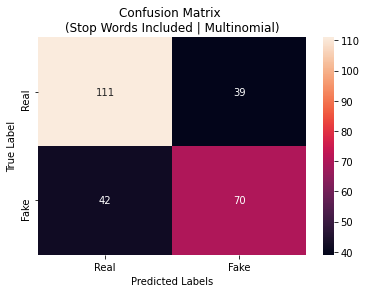

In [12]:
y_true,y_pred,accuracy = run_all(includeStopWords=1,isBoolean=0)
confusion_matrix = confusion_matrixx(y_true,y_pred)
precision,recall,f1 = precision_recall_f1(confusion_matrix)
print("Accuracy: ",accuracy,"%",sep="")
print("Precision: ",round(precision,5))
print("Recall: ",round(recall,5))
print("F1-Score: ",round(f1,5))
sns.heatmap(confusion_matrix,annot=True, fmt='g',xticklabels=["Real","Fake"],yticklabels=["Real","Fake"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Label")
plt.title("Confusion Matrix \n(Stop Words Included | Multinomial)")
plt.show()

# Second Analysis is excluding the stop words and Multinomial

Accuracy: 69.84700000000001%
Precision:  0.72667
Recall:  0.7415
F1-Score:  0.73401


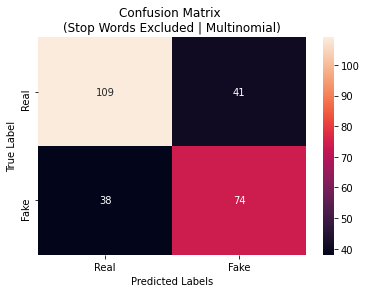

In [13]:
y_true,y_pred,accuracy = run_all(includeStopWords=0,isBoolean=0)
confusion_matrix = confusion_matrixx(y_true,y_pred)
precision,recall,f1 = precision_recall_f1(confusion_matrix)
print("Accuracy: ",accuracy,"%",sep="")
print("Precision: ",round(precision,5))
print("Recall: ",round(recall,5))
print("F1-Score: ",round(f1,5))
sns.heatmap(confusion_matrix,annot=True, fmt='g',xticklabels=["Real","Fake"],yticklabels=["Real","Fake"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Label")
plt.title("Confusion Matrix \n(Stop Words Excluded | Multinomial)")
plt.show()

# Third Analysis is including stop words but Boolean

Accuracy: 77.09899999999999%
Precision:  0.85333
Recall:  0.77108
F1-Score:  0.81013


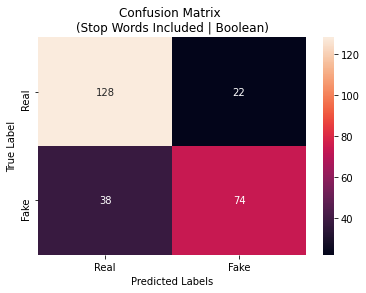

In [14]:
y_true,y_pred,accuracy = run_all(includeStopWords=1,isBoolean=1)
confusion_matrix = confusion_matrixx(y_true,y_pred)
precision,recall,f1 = precision_recall_f1(confusion_matrix)
print("Accuracy: ",accuracy,"%",sep="")
print("Precision: ",round(precision,5))
print("Recall: ",round(recall,5))
print("F1-Score: ",round(f1,5))
sns.heatmap(confusion_matrix,annot=True, fmt='g',xticklabels=["Real","Fake"],yticklabels=["Real","Fake"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Label")
plt.title("Confusion Matrix \n(Stop Words Included | Boolean)")
plt.show()

# Fourth Analysis is excluding stop words but Boolean 

Accuracy: 76.336%
Precision:  0.85333
Recall:  0.7619
F1-Score:  0.80503


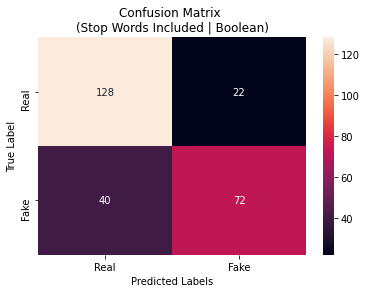

In [15]:
y_true,y_pred,accuracy = run_all(includeStopWords=0,isBoolean=1)
confusion_matrix = confusion_matrixx(y_true,y_pred)
precision,recall,f1 = precision_recall_f1(confusion_matrix)
print("Accuracy: ",accuracy,"%",sep="")
print("Precision: ",round(precision,5))
print("Recall: ",round(recall,5))
print("F1-Score: ",round(f1,5))
sns.heatmap(confusion_matrix,annot=True, fmt='g',xticklabels=["Real","Fake"],yticklabels=["Real","Fake"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Label")
plt.title("Confusion Matrix \n(Stop Words Included | Boolean)")
plt.show()

---

# Report

## Things covered:

* Created an integrated implementation of Multinomial and Boolean Naive Bayes that can be interchanged using parameters
* Following evaluation parameters were used:
        Accuracy
        Precision
        Recall
        F-1 Score
        
* Experimentation was done with and without stop words


## Assumptions:
* The Naive Bayes algorithm takes into account the Bag-of-words approach and assumes each probability is independent. Thus  

$ P(a,b|e) = P(a|e).P(b|e) $

* In case the document frequency becomes equal in both classes i.e. Real and Fake, the benefit of the doubt is given to the news and is considered Real.


## Results:

### Scenarios Tested:

Four different scenarios were tested. Please find below the results 

|Scenario No| Multinomial/Binomial | StopWords|
|-----------|-----------------------|--------------------|
|1|Multinomial|Included|
    |2|Multinomial|Excluded|
    |3|Binomial|Included|
    |4|Binomial|Excluded|
    
### Evaluation Metrics:
* Accuracy:
    * $\frac{\sum Correct}{\sum Total} \times 100$
    *  Weak metric as it provides very less information about the model efficiency
    
* Precision:
    * $\frac{TP}{TP+FP}$
    * Checks what portion of positive identifications were correct? 
    * Doesn't check for the negatives
    
* Recall:
    * $\frac{TP}{TP+FN}$
    * Checks what proportion of positive identifications were identified correctly? 
    
* F1-Score:
    * A more reliable measure that takes into account Precision and Recall and gives out a score
    * $2 \times \frac{Precision \times Recall}{Precision+Recall}$
    
    
### Evaluation Summary:

| Scenario | Type        | Stop Words | Accuracy | Precision | Recall | F-1 Score |
|----------|-------------|------------|----------|-----------|--------|-----------|
| 1        | Multinomial | Included   | 69%      | 0.74      | 0.725  | 0.73      |
| 2        | Multinomial | Excluded   | 69.84%   | 0.72      | 0.74   | 0.73      |
| 3        | Binomial    | Included   | 77%      | 0.85      | 0.771  | 0.8101    |
| 4        | Binomial    | Excluded   | 76.33%   | 0.853     | 0.762  | 0.805     |


### Observations and Conclusion:
* Using Binomial definitely increased the Accuracy, precision, recall and F-1 Scores
* Excluding Stop Words did good effect in case of multinomial but for binomial, results are almost the same
* It is observed that True Positives for scenario 3 and 4 are almost same but False Negatives decreased in case 4 which means excluding stop words increased confusion.
* This technique heavily relies on the word tokenization and using an even stronger tokenizer in urdu words, we may further improve our performance